# Linear Neural Network - Softmax Regression

In this notebook, we formulate the Softmax Regression technique for multiclass classification as a Linear Neural Network (LNN) model. We use the **Iris dataset** for our classification tasks.

We use learning curves to monitor the model’s performance (accuracy and loss) on both the training and validation data over iterations (epochs).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

## Decision Boundary: Using Various Thresholds for a Class Probability

We define a function to show the decision boundaries at various thresholds of a class probability. Using the different estimates for a single class, we generate a contour plot. 

In [2]:
def decision_boundary_class_colored(clf, X):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points        
    y_pred = np.argmax(clf.predict(X_new), axis=-1).reshape(x1.shape)
    
   
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.summer, alpha=0.9)

## Multiclass Dataset


We will use the iris dataset, which is a multivariate data set.

This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica

There are 4 features:

- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)


We will use two features (i.e., petal length, petal width).

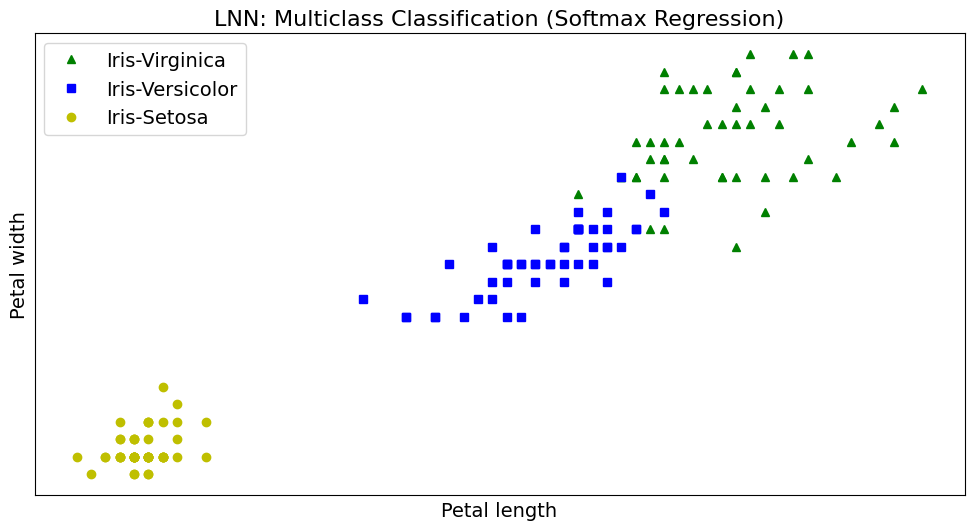

In [3]:
iris = load_iris()

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

label = y

plt.figure(figsize=(12, 6))    
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("LNN: Multiclass Classification (Softmax Regression)", fontsize=16)
plt.xticks(())
plt.yticks(())

plt.show()

## Create Train and Test Subsets

In [4]:
# Create train and test subsets from the full dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)


print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)


Shape of Training Samples:  (120, 2)
Shape of Training Labels:  (120,)

Shape of Testing Samples:  (30, 2)
Shape of Testing Labels:  (30,)


## Standardize the Dataset

In [5]:
scaler = StandardScaler()

# Fit on the training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Create an LNN Model

We use the Keras Dense layer to create an LNN model for Softmax Regression. In a Dense layer, each neuron is fully connected to all inputs/neurons of the previous layer.

To build this LNN model, we will use the Sequential class from tf.keras.models, a module in TensorFlow's Keras API that allows us to stack layers, such as Dense layers, in a linear sequence. This makes it easy to define models layer by layer.

The LNN model:
- Has 3 output neurons, corresponding to the Iris 3-class classification problem.
- Uses the softmax activation function to convert the output into probabilities.


First, we need to specify the shape of the input using the Input layer, which instantiates a Keras tensor—a symbolic TensorFlow tensor.
- The "shape" parameter is a tuple of integers that defines the dimensionality of the input vectors. In this demo, the input is a 2D vector, so we use the tuple (2,). For image classification tasks, where inputs are matrices (e.g., a 28x28 image), the "shape" tuple would be (28, 28). Alternatively, if we flatten the input matrix (28x28=784), we would use the tuple (784,) to represent the dimensions of the flattened vector. Note that the batch size is not included in the shape definition.


Dense layer:
- kernel_initializer: We initialize the weights (the kernel) to zero. This is acceptable for logistic/softmax regression, but for nonlinear networks like Multi-layer Perceptrons (MLPs), we need to use initializers like Glorot or He, which assign small random values to the weights.
- activation: We use softmax activation.

In [6]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise, memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)

number_of_classes = 3

'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = tf.keras.models.Sequential(name="LNN_Multiclass_Classifier")
model.add(tf.keras.layers.Input(shape=[2,]))
model.add(tf.keras.layers.Dense(units=number_of_classes, 
                                kernel_initializer="zeros", 
                                activation="softmax"))

# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary() 

Model: "LNN_Multiclass_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
CPU times: user 48.2 ms, sys: 2.98 ms, total: 51.2 ms
Wall time: 16.1 ms


## Compile & Train the LNN Model

A Keras model automatically employs the **backpropagation** algorithm to train an artificial neural network (ANN). However, we need to specify an optimization algorithm.

There are various advanced optimizers available, but for our LNN, we will use the **stochastic gradient descent (SGD)** optimizer, which requires setting an appropriate learning rate.

We will implement mini-batch SGD, so it's essential to specify both the batch size and the number of epochs.


### History Object
To monitor the performance of our model during training, we will utilize the tf.keras.callbacks.History object. This object automatically tracks key metrics, such as loss and accuracy, for each epoch across both training and validation datasets.

The History object is automatically applied when a model is trained using the fit() method in TensorFlow Keras. It records metrics, including:
- Loss for both training and validation data.
- Accuracy (or other metrics) for both training and validation data.

By analyzing this recorded history, we can assess the effectiveness of our training process and make necessary adjustments.


In [7]:
'''
Define the optimizer
An optimizer object implements an optimization algorithm used to minimize the loss function during model training.
Below, the stochastic gradient descent (SGD) optimizer is used.
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)

'''
Compile the model

The model.compile() method is used to configure the model for training. 
It prepares the model for the training process by defining how the model will learn and be evaluated.
It specifies three key components:
- Optimizer: The algorithm used to update the weights of the model (e.g., SGD).
- Loss function: The function the model tries to minimize, 
  which measures how well the model's predictions match the true values (e.g., binary_crossentropy, mean_squared_error).
- Metrics: Additional evaluation criteria for the model's performance, such as accuracy, 
           which are not involved in training but are used for monitoring.

'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Set the epochs and batch size
'''
no_of_epochs = 100
size_of_mini_batch = 64

'''
Train the model
The History object is applied when a model is trained using the fit() method.
It automatically tracks the performance of a model during training. 
It records key metrics such as loss and accuracy for each epoch, for both training and validation data.
'''
history = model.fit(X_train, # Training feature data
                    y_train, # Training target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1. 
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 
                   )

Epoch 1/100
2/2 [==============================] - 0s 53ms/step - loss: 1.0538 - accuracy: 0.4630 - val_loss: 0.9059 - val_accuracy: 0.5833
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 0.8623 - accuracy: 0.7037 - val_loss: 0.7955 - val_accuracy: 0.5833
Epoch 3/100
2/2 [==============================] - 0s 9ms/step - loss: 0.7471 - accuracy: 0.7037 - val_loss: 0.7284 - val_accuracy: 0.5833
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6735 - accuracy: 0.7037 - val_loss: 0.6833 - val_accuracy: 0.5833
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6238 - accuracy: 0.7037 - val_loss: 0.6513 - val_accuracy: 0.5833
Epoch 6/100
1/2 [==============>...............] - ETA: 0s - loss: 0.5598 - accuracy: 0.7500

2024-09-21 11:31:09.714512: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 8ms/step - loss: 0.5882 - accuracy: 0.7037 - val_loss: 0.6235 - val_accuracy: 0.6667
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5607 - accuracy: 0.7130 - val_loss: 0.6024 - val_accuracy: 0.6667
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5381 - accuracy: 0.7315 - val_loss: 0.5841 - val_accuracy: 0.6667
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5197 - accuracy: 0.7407 - val_loss: 0.5686 - val_accuracy: 0.6667
Epoch 10/100
2/2 [==============================] - 0s 9ms/step - loss: 0.5036 - accuracy: 0.7500 - val_loss: 0.5530 - val_accuracy: 0.6667
Epoch 11/100
2/2 [==============================] - 0s 8ms/step - loss: 0.4894 - accuracy: 0.7500 - val_loss: 0.5391 - val_accuracy: 0.6667
Epoch 12/100
2/2 [==============================] - 0s 8ms/step - loss: 0.4774 - accuracy: 0.7593 - val_loss: 0.5289 - val_accuracy: 0.6667
Epoch 13/100
2/2 [==================

## Learning Curve


A learning curve is a graphical representation that shows the relationship between a model’s performance (often measured by metrics like accuracy, loss, or error) and the amount of training data or iterations (epochs).

In the context of machine learning, the learning curve typically tracks two main aspects:

- Training Performance: The model's performance on the training data over time.
- Validation/Test Performance: The model's performance on unseen validation or test data over time.

Key Insights from a Learning Curve:
- Convergence: When both training and validation curves flatten, the model has likely converged.
- Overfitting: If the training performance is good but the validation performance is poor, the model is overfitting.
- Underfitting: If both the training and validation performance are poor, the model may be underfitting.




## A Function For Generating Learning Curves (Accuracy & Loss)

In [8]:
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

Epochs:  100


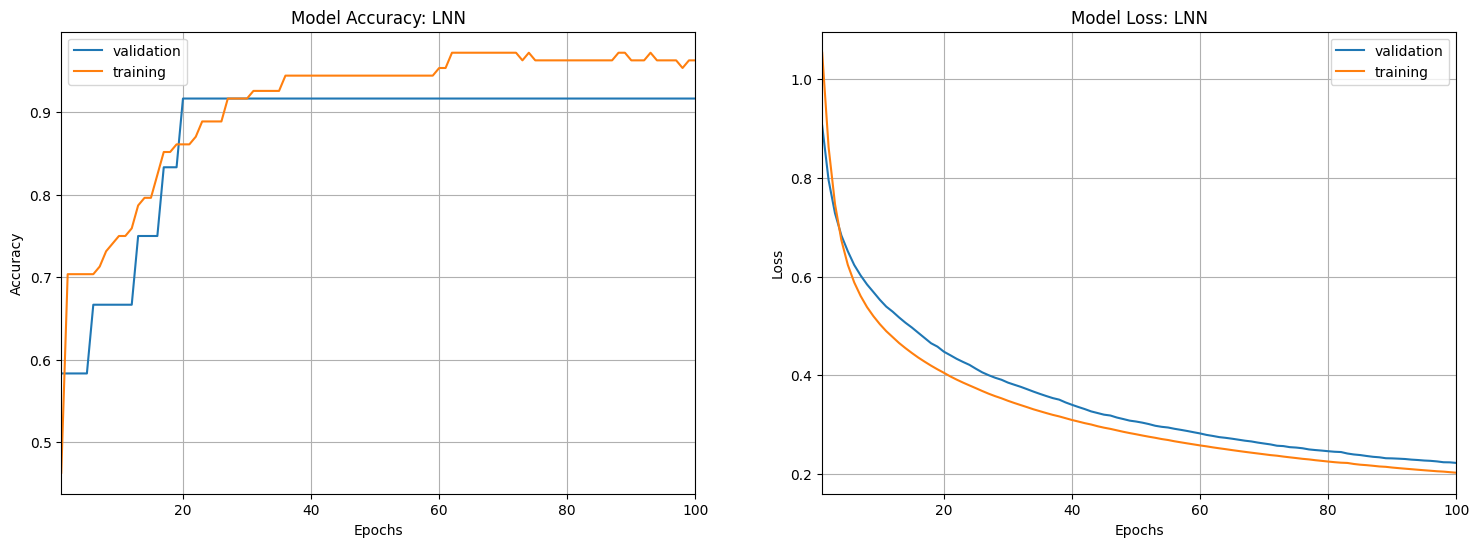

In [9]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

plot_learning_curves(history, numOfEpochs, "LNN")

## Evaluate the LNN Model

In [10]:
print("Epochs: ", numOfEpochs)

# Display train and test performance metrics (accuracy and loss)
print("\nTrain Data: Loss & Accuracy: ", model.evaluate(X_train, y_train, verbose=0))
print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))


'''
Compute the train accuracy
'''
# The model.predict() method returns 3 probabilities per class for each instance (Dimension Nx3)
y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)

'''
Compute the test accuracy
'''
# The model.predict() method returns 3 probabilities per class for each instance (Dimension Nx3)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class
test_accuracy = np.mean(y_test_predicted == y_test)



print("\nTrain Accuracy: ", train_accuracy)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  100

Train Data: Loss & Accuracy:  [0.20366856455802917, 0.9583333134651184]

Test Data: Loss & Accuracy:  [0.23531809449195862, 1.0]
1/1 [==============================] - 0s 6ms/step

Train Accuracy:  0.9583333333333334

Test Accuracy:  1.0

Test Confusion Matrix:
[[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Plot The Decision Boundary

313/313 [==============================] - 0s 179us/step


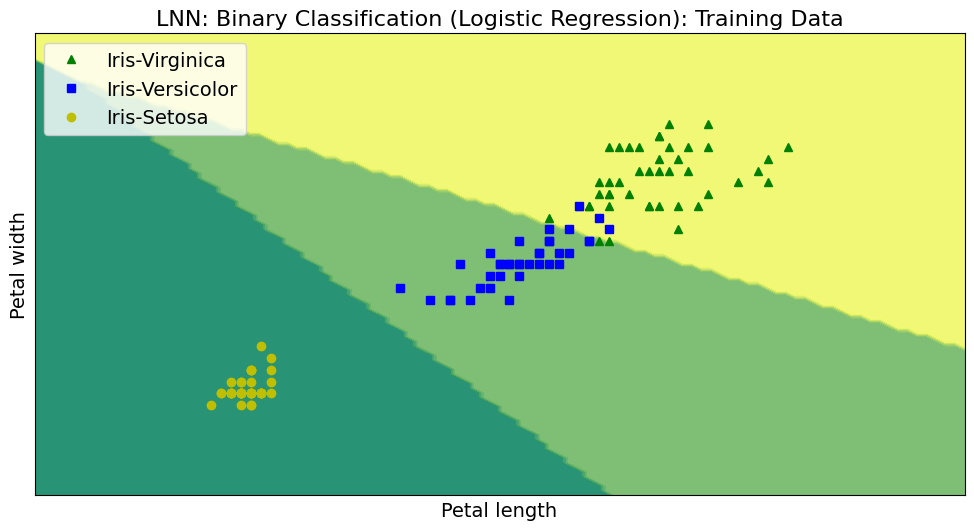

313/313 [==============================] - 0s 172us/step


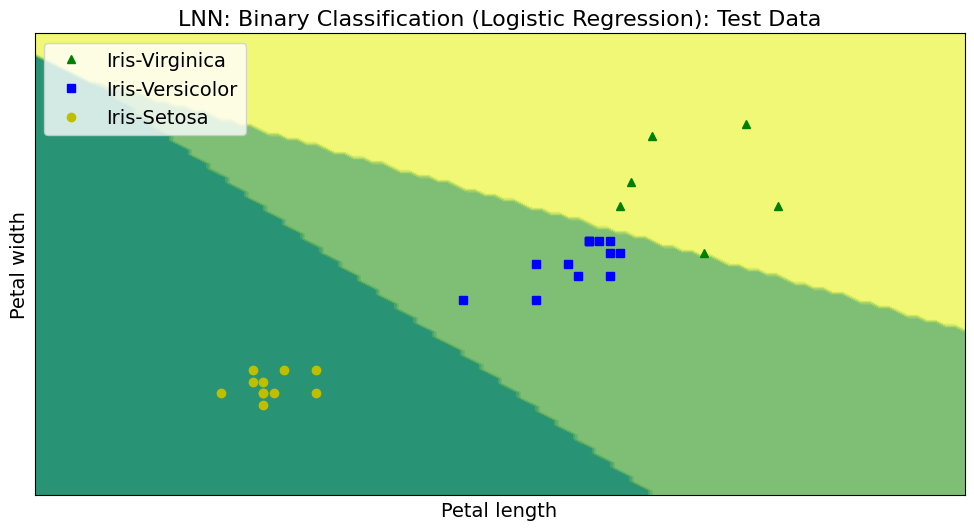

In [11]:
plt.figure(figsize=(12, 6))    

decision_boundary_class_colored(model, X_train)

plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "g^", label="Iris-Virginica")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "yo", label="Iris-Setosa")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("LNN: Binary Classification (Logistic Regression): Training Data", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()


plt.figure(figsize=(12, 6))    

decision_boundary_class_colored(model, X_test)

plt.plot(X_test[y_test==2, 0], X_test[y_test==2, 1], "g^", label="Iris-Virginica")
plt.plot(X_test[y_test==1, 0], X_test[y_test==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X_test[y_test==0, 0], X_test[y_test==0, 1], "yo", label="Iris-Setosa")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("LNN: Binary Classification (Logistic Regression): Test Data", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()



